In [51]:
import numpy as np
from scipy import linalg
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from complexPyTorch.complexLayers import ComplexLinear
from IPython.display import clear_output

In [52]:
class statevector(np.ndarray): #extends the np.ndarray class to add functionalities like normalize, evolve under hamiltonian and also obtain density matrix
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def get_norm(self):
        normVal = self.H()@self
        try:
            return normVal[0][0].real
        except:
            return normVal.real
    
    def normalize(self):
        if self.get_norm() != 0:
            self[:] = self/(self.get_norm()**0.5)
        return self
    
    def evolve(self, Hamiltonian, time, method='exact', dt=0):
        if method not in ['exact', 'trotter']:
            raise AttributeError(f"The specified method '{method}' does not exist.")
        
        if method == 'exact':
            evolvedstate = linalg.expm(-1j*Hamiltonian*time)@self
        else:
            size, __ = Hamiltonian.shape
            trotter_term = (operator(np.identity(size)) - 1j*Hamiltonian*dt)
            N = int(time/dt)
            evolvedstate = self
            for __ in range(N):
                evolvedstate = trotter_term@evolvedstate
            evolvedstate.view(statevector).normalize()
        
        self[:] = evolvedstate
        return self
    
    def get_rho(self):
        state = np.copy(self).view(statevector)
        state.normalize()
        rho = state@state.H()
        return rho.view(operator)


class operator(np.ndarray): #extends the np.ndarray class to add functionalities like expectation value of the operator for a given statevector
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def expectation_value(self, state:statevector):
        state.normalize()
        exp_val =  state.H()@self@state
        return exp_val[0][0].real

def natural_range(*args): #used to prevent confusions in coversion from natural index used in Hamiltonian and other Operators to python index
    '''
    natural_range(start, end) yields (i_p, i_n) where i_p is the programming index starting from start-1 to end-1 and i_n is the natural index starting from start to end. 
    'start' will default to 1 if natural_range is called with single arg.
    '''
    try:
        start = args[-2] - 1
    except:
        start = 0
    
    end = args[-1]
    
    for i in range(start, end):
        yield (i, i+1)


In [53]:
# basic defs
sx = operator([[0, 1],[1, 0]])
sy = operator([[0, -1j],[1j, 0]])
sz = operator([[1, 0],[0, -1]])
sp = (sx + 1j*sy)/2
sm = (sx - 1j*sy)/2
id_2 = operator(np.eye(2))

In [54]:
class PINN(nn.Module):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            num_outputs: int=1,
            activation: nn.Module = nn.Tanh()
    ):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.num_outputs = num_outputs
        self.activation = activation

        layers = [ComplexLinear(num_inputs, num_neurons)]

        for _ in range(num_hidden_layers):
            layers.append(activation)
            layers.append(ComplexLinear(num_neurons, num_neurons))
        
        layers.append(activation)
        layers.append(ComplexLinear(num_neurons, num_outputs))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [55]:
def loss_function(
        model: nn.Module, 
        loss_operator: operator,
        input: torch.Tensor
)-> torch.Tensor:
        
        amplitudes = model(input)
        amplitudes_H = torch.conj(amplitudes).T
        norm = torch.matmul(amplitudes_H, amplitudes).real
        amplitudes = amplitudes/torch.sqrt(norm)
        amplitudes_H = amplitudes_H/torch.sqrt(norm)

        loss_operator = torch.tensor(loss_operator)
        loss = torch.matmul(torch.matmul(amplitudes_H, loss_operator), amplitudes)

        return loss.real

In [56]:
def get_pauli(
        N:int,
        ) -> tuple[list[operator]]:
    sigma_p = []
    sigma_m = []
    sigma_z = []

    sp_listform = [[sp if k==l else id_2 for k in range(N)] for l in range(N)]
    sm_listform = [[sm if k==l else id_2 for k in range(N)] for l in range(N)]
    sz_listform = [[sz if k==l else id_2 for k in range(N)] for l in range(N)]

    for i in range(N):
        temp = sp_listform[i][0]
        for pauli in sp_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_p.append(temp)

        temp = sm_listform[i][0]
        for pauli in sm_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_m.append(temp)

        temp = sz_listform[i][0]
        for pauli in sz_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_z.append(temp)

    id_N = operator(np.eye(2**N))

    return sigma_p, sigma_m, sigma_z, id_N

def get_hamiltonian(
        N:int, 
        coeffs: tuple[float]
        )->operator:
    '''
    takes N: numer of lattice sites and coeffs: (M, J, W) and returns the Hamiltonian for the system
    '''
    (sigma_p, sigma_m, sigma_z, id_N) = get_pauli(N)
    (M, J, W) = coeffs

    # the natural_range method returns the tuple (python index, natural index), which I have denoted by adding _p and _n to the indices

    # H_Z

    hamiltonian_z1 = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        hamiltonian_z1 += (-1)**n_n*sigma_z[n_p]
    hamiltonian_z1 *= (M/(2*W))

    hamiltonian_z2 = operator(np.zeros_like(id_N))
    
    for (n_p, n_n) in natural_range(1, N-1):
        coeff = 1 - (-1)**n_n
        if coeff!=0:
            term = operator(np.zeros_like(id_N))
            for (l_p, l_n) in natural_range(1, n_n):
                term += sigma_z[l_p]
            hamiltonian_z2 += coeff*term

    hamiltonian_z2 *= (-J)/(4*W)

    hamiltonian_z = hamiltonian_z1 + hamiltonian_z2

    # H_{\pm}

    hamiltonian_pm = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-1):
        term = sigma_p[n_p]@sigma_m[n_p + 1]
        hamiltonian_pm += term + term.H()
    
    # H_{ZZ}
    hamiltonian_zz = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-2):
        for (l_p, l_n) in natural_range(n_n+1, N-1):
            hamiltonian_zz += (N - l_n)*sigma_z[n_p]@sigma_z[l_p]
    hamiltonian_zz *=  (J/(2*W))

    hamiltonian = hamiltonian_z + hamiltonian_pm + hamiltonian_zz

    return hamiltonian

def get_particle_density(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    particle_density = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        particle_density += ((-1)**n_n)*sigma_z[n_p] + id_N

    particle_density /= (2*N)

    return particle_density

def get_order_parameter(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    order_parameter = operator(np.zeros_like(id_N))

    for (i_p, i_n) in natural_range(1, N):
        for (j_p, j_n) in natural_range(i_n+1, N):
            order_parameter += ( ((-1)**i_n)*sigma_z[i_p] + id_N ) @ ( ((-1)**j_n)*sigma_z[j_p] + id_N ) 

    order_parameter /= (2*N*(N-1))

    return order_parameter

In [57]:
def train_step(optimizer, model, input, loss_operator):
        optimizer.zero_grad()
        loss = loss_function(model=model, loss_operator=loss_operator, input=input)
        loss.backward()
        optimizer.step()

        return loss

In [70]:
N = 6
masses = np.linspace(-5, 5, 11)
inputs = torch.linspace(0, 2**N-1, 2**N, dtype=torch.complex64).reshape(2**N, -1)

num_inputs = 1
num_outputs = 1
num_hidden_layers = 5
num_neurons = 5
learning_rate = 0.001
epochs = 50000

particle_density_op = get_particle_density(N)
particle_densities = []



In [71]:
for m in masses:
    print(f'Mass={m}')
    coeffs = (m, 1, 1)
    psi = PINN(num_inputs=num_inputs, num_outputs=num_outputs, num_hidden_layers=num_hidden_layers, num_neurons=num_neurons)
    optimizer = optim.Adam(psi.parameters(), lr=learning_rate)
    hamiltonian = get_hamiltonian(N, coeffs)
    old_energy = 0

    for epoch in range(epochs):
        energy = train_step(optimizer=optimizer, model=psi, loss_operator=hamiltonian, input=inputs).detach().numpy()[0,0]
        perc_change = abs(energy - old_energy)*100/energy
        old_energy = energy

        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Energy: {energy}, perc_change: {perc_change}')


    state = statevector(psi(inputs).detach().numpy())
    particle_densities.append(particle_density_op.expectation_value(state))
    clear_output()
    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


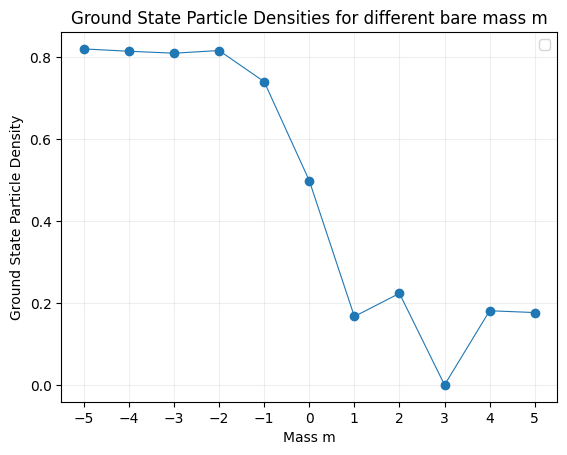

In [75]:
fig, ax = plt.subplots()
ax.plot(masses, particle_densities, '.-', linewidth=0.8, markersize=12)
ax.set_xticks(masses)
ax.set_xlabel("Mass m")
ax.set_ylabel("Ground State Particle Density")
ax.set_title("Ground State Particle Densities for different bare mass m")
ax.legend(loc='best')
ax.grid(True, alpha=0.2)
plt.show()